# Game classification network


### Imports

In [1]:
# Imports
!pip install procgen
!wget https://raw.githubusercontent.com/ThomasConrad/ProcgenDeepLearning/main/utils.py
!wget https://raw.githubusercontent.com/ThomasConrad/ProcgenDeepLearning/main/classifier.py
!wget https://raw.githubusercontent.com/ThomasConrad/ProcgenDeepLearning/main/TrainedClassifier.pt
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import make_env, Storage, orthogonal_init
from classifier import Net

import csv

--2020-12-30 15:50:26--  https://raw.githubusercontent.com/ThomasConrad/ProcgenDeepLearning/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17786 (17K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]  17.37K  --.-KB/s    in 0s      

2020-12-30 15:50:26 (112 MB/s) - ‘utils.py.2’ saved [17786/17786]

--2020-12-30 15:50:26--  https://raw.githubusercontent.com/ThomasConrad/ProcgenDeepLearning/main/classifier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1635 (1.6K) [text/plain]
Saving to:

#### view frame

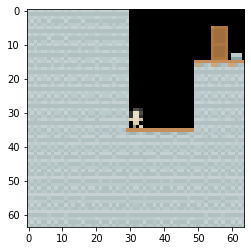

In [2]:
from PIL import Image
from matplotlib import pyplot as plt
from utils import make_env, Storage, orthogonal_init

env = make_env(1, num_levels=1,env_name='coinrun')
ob = env.reset()
img = ob[0].permute(1,2,0).numpy()
plt.imshow(img)

## Generate images

In [5]:
import argparse
import sys
from utils import make_env, Storage, orthogonal_init
import gym
import os
import numpy as np
from gym import wrappers, logger
from PIL import Image
import pickle as pkl
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch

class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done,num_envs):
        action = []
        for i in range(num_envs):
            action.append(self.action_space.sample())
        return torch.Tensor(action)
    
num_envs = 50
num_steps = 256
num_levels = 100
#env_names = ['bigfish', 'bossfight', 'caveflyer', 'chaser', 'climber', 'coinrun', 'dodgeball', 'fruitbot', 'heist', 'jumper', 'leaper', 'maze', 'miner', 'ninja', 'plunder', 'starpilot',]
env_names = ['bigfish','coinrun','starpilot']

In [6]:
episode_count = 2
labels = np.empty(num_steps*len(env_names)*episode_count*num_envs)
data = np.empty((num_steps*len(env_names)*episode_count*num_envs,3,64,64))
counter = -1
for j,env_name in enumerate(env_names):
    print(f"doing {env_name}")
    env = make_env(num_envs, num_levels=num_levels,env_name=env_name)

    agent = RandomAgent(env.action_space)
    
    reward = 0
    done = False
    ob = env.reset()
    for i in range(episode_count):
        for step in range(num_steps):
            action = agent.act(ob, reward, done,num_envs)
            ob, reward, done, _ = env.step(action)
            img = ob.numpy()
            for k in range(num_envs):
                data[counter] = img[k]
                labels[counter] = j
                counter += 1
            if done.any():
                break
    env.close()
    
data = data[0:counter]
labels = labels[0:counter]
with open('data.pkl','wb') as f:
    pkl.dump(data,f)
with open('datalabels.pkl','wb') as f:
    pkl.dump(labels,f)

doing bigfish
doing coinrun
doing starpilot


#### Load if pickled already

In [ ]:
with open('data.pkl','rb') as f:
    data = pkl.load(f)
with open('datalabels.pkl','rb') as f:
    labels = pkl.load(f)

## Setup training and test sets

In [7]:
# CUDA for PyTorch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
max_epochs = 5
batch_size = 6
# Datasets
print()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# Generators
training_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,shuffle=True, num_workers=2)

validation_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
testloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=2)

print("# Training data")
print("Number of points:", len(training_set))
print("# Validation data")
print("Number of points:", len(validation_set))



# Training data
Number of points: 7479
# Validation data
Number of points: 1870


### Define CNN

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.conv_1 = nn.Conv2d(in_channels=input_channels,
                            out_channels=32,
                            kernel_size=5, 
                            padding=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, 
                            out_channels=64,
                            kernel_size=5, 
                            padding=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.conv2_drop = nn.Dropout2d()

        self.dense_features = 64 * input_height//2 * input_width//2
        self.dense = nn.Linear(in_features=self.dense_features, 
                                out_features=50,
                                bias=True)
        self.dropout = nn.Dropout(p=0.5)
        
        self.dense_out = nn.Linear(in_features=50,
                             out_features=num_classes,
                                bias=False)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv_2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = self.conv2_drop(x)
        x = x.view(-1, self.dense_features)
        x = F.relu(self.dense(x))

        return F.log_softmax(self.dense_out(x), dim=1)
    
X_train, X_test, y_train, y_test
net = Net(3,64,64,len(env_names))
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

##converting network to cuda-enabled
Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (dense): Linear(in_features=65536, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense_out): Linear(in_features=50, out_features=3, bias=False)
)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), momentum=0.8, lr=0.001)

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x

### Training loop

In [10]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0.0
    i = 0
    for inputs, labels in trainloader:
        # Transfer to GPU
        labels = labels.long()
        inputs, labels = get_variable(Variable(inputs)), get_variable(Variable(labels))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.data.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] train loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        i += 1

print('Completed training!')
torch.save(net.state_dict, 'TrainedClassifier.pt')

[1,   100] train loss: 0.2228
[1,   200] train loss: 0.1248
[1,   300] train loss: 0.0424
[1,   400] train loss: 0.0401
[1,   500] train loss: 0.0245
[1,   600] train loss: 0.0217
[1,   700] train loss: 0.0173
[1,   800] train loss: 0.0047
[1,   900] train loss: 0.0032
[1,  1000] train loss: 0.0020
[1,  1100] train loss: 0.0049
[1,  1200] train loss: 0.0049
[2,   100] train loss: 0.0036
[2,   200] train loss: 0.0011
[2,   300] train loss: 0.0007
[2,   400] train loss: 0.0007
[2,   500] train loss: 0.0004
[2,   600] train loss: 0.0004
[2,   700] train loss: 0.0007
[2,   800] train loss: 0.0003
[2,   900] train loss: 0.0009
[2,  1000] train loss: 0.0017
[2,  1100] train loss: 0.0003
[2,  1200] train loss: 0.0005
[3,   100] train loss: 0.0003
[3,   200] train loss: 0.0002
[3,   300] train loss: 0.0004
[3,   400] train loss: 0.0001
[3,   500] train loss: 0.0020
[3,   600] train loss: 0.0013
[3,   700] train loss: 0.0006
[3,   800] train loss: 0.0004
[3,   900] train loss: 0.0003
[3,  1000]

In [15]:
torch.save(net.state_dict(), 'TrainedClassifierMulti.pt')

### Analyze training results

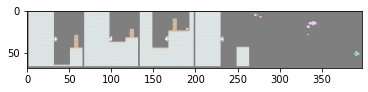

GroundTruth:   coinrun coinrun coinrun coinrun starpilot bigfish
Predicted:     coinrun coinrun coinrun coinrun starpilot bigfish


In [12]:
images, labels = iter(testloader).next()
labels = labels.int()
def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % env_names[labels[j]] for j in range(batch_size)))

outputs = net(get_variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % env_names[predicted[j]] for j in range(batch_size)))

In [13]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(get_variable(Variable(images)))
    _, predicted = torch.max(outputs.cpu().data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(validation_set), 100 * correct.true_divide(total)))

Accuracy of the network on the 1870 test images: 99.89 %
